<a href="https://colab.research.google.com/github/erikbwu/RETEV2025/blob/main/RetevBest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

def load_eeg_data(eeg_csv_path):
    """
    Load EEG CSV file. Expects a timestamp column ('sys_time' or 'systime') and EEG channel columns.
    Returns timestamps (float64) and EEG data (float32).
    """
    df = pd.read_csv(eeg_csv_path)
    # Identify timestamp column
    if 'sys_time' in df.columns:
        ts_col = 'sys_time'
    elif 'systime' in df.columns:
        ts_col = 'systime'
    else:
        raise KeyError("Timestamp column not found in EEG CSV.")
    eeg_timestamps = df[ts_col].values.astype(np.float64)
    # Drop timestamp column to get EEG channels
    eeg_data = df.drop(columns=[ts_col]).values.astype(np.float32)
    x_new = eeg_data[:, 1:]
    print(x_new)
    return eeg_timestamps, x_new

def load_event_data(event_csv_path):
    """
    Load event CSV file. Expects a time column ('systime' or 'timestamp') and a 'key' (event label) column.
    Returns event times (float64) and labels (string).
    """
    df = pd.read_csv(event_csv_path)
    if 'systime' in df.columns:
        ts_col = 'systime'
    elif 'timestamp' in df.columns:
        ts_col = 'timestamp'
    else:
        ts_col = df.columns[0]  # fallback to first column
    event_times = df[ts_col].values.astype(np.float64)
    if 'key' in df.columns:
        event_labels = df['key'].values
    elif 'event' in df.columns:
        event_labels = df['event'].values
    else:
        raise KeyError("Event label column not found.")
    return event_times, event_labels

def find_closest_sample_idx(eeg_timestamps, event_time):
    """
    Find index of EEG sample whose timestamp is closest to the given event time.
    """
    idx = np.argmin(np.abs(eeg_timestamps - event_time))
    return idx

def create_event_mask(eeg_timestamps, event_times, event_labels):
    """
    Create a binary mask (0/1) over EEG samples. We mark samples as 1 between each
    'press' and corresponding 'release' event, indicating an active period.
    """
    n_samples = len(eeg_timestamps)
    mask = np.zeros(n_samples, dtype=np.int32)
    press_idx = None
    for time, label in zip(event_times, event_labels):
        idx = find_closest_sample_idx(eeg_timestamps, time)
        lab = str(label).lower()
        if 'press' in lab:
            press_idx = idx
        elif 'release' in lab and press_idx is not None:
            release_idx = idx
            start = min(press_idx, release_idx)
            end = max(press_idx, release_idx)
            mask[start:end+1] = 1
            press_idx = None
    return mask


In [20]:
def bandpass_filter(eeg_data, fs, lowcut=1.0, highcut=50.0, order=4):
    """
    Bandpass filter the EEG data using a Butterworth filter (applied along time axis).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, eeg_data, axis=0)
    return filtered.astype(np.float32)


In [21]:
def segment_windows(eeg_data, event_mask, fs, window_size_sec=0.5, step_size_sec=0.25, threshold=0.15):
    """
    Segment EEG into windows of given duration with overlap.
    Label a window as 1 if >50% of its samples have event_mask=1.
    Returns X of shape (n_windows, n_channels, window_samples) and labels y.
    """
    window_size = int(window_size_sec * fs)
    step_size = int(step_size_sec * fs)
    n_samples, n_channels = eeg_data.shape
    windows = []
    labels = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        segment = eeg_data[start:end, :].T    # (channels, time)
        seg_mask = event_mask[start:end]
        label = 1 if np.sum(seg_mask) > (threshold * window_size) else 0
        windows.append(segment)
        labels.append(label)
    X = np.stack(windows)          # (n_windows, channels, time)
    y = np.array(labels, dtype=np.int64)
    return X, y


In [22]:
class EEGDataset(Dataset):
    """
    PyTorch Dataset for EEG windows.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class EEGNet(nn.Module):
    """
    EEGNet: compact CNN with depthwise & separable convolutions:contentReference[oaicite:2]{index=2}.
    Expects input shape (batch, channels, time).
    """
    def __init__(self, n_channels=8, n_time=125, n_classes=2):
        super(EEGNet, self).__init__()
        # First temporal convolution (1 x 51 filter)
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16)
        )
        # Depthwise spatial convolution (n_channels x 1 filter, groups=16)
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(n_channels, 1), groups=16, bias=False),
            nn.BatchNorm2d(32), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(0.25)
        )
        # Separable convolution (1 x 15 filter)
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.25)
        )
        # Compute output feature size after convolutions
        def conv_output_size(length, kernel_size, padding=0, stride=1):
            return (length + 2*padding - (kernel_size - 1) - 1)//stride + 1
        out_time = n_time
        out_time = conv_output_size(out_time, 51, padding=25)
        out_time = out_time // 4  # after first AvgPool
        out_time = conv_output_size(out_time, 15, padding=7)
        out_time = out_time // 8  # after second AvgPool
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 1 * out_time, n_classes)
        )

    def forward(self, x):
        # x: (batch, channels, time)
        x = x.unsqueeze(1)          # reshape to (batch, 1, channels, time)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classifier(x)
        return x


In [12]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss / total, correct / total


In [27]:
##Alternate

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

def train_model(model, train_loader, val_loader, n_epochs, lr=0.001, save_path='best_model.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, dtype=torch.float32), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device, dtype=torch.float32), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved at epoch {epoch+1}")

    plot_training_results(train_losses, val_losses, val_accuracies)
    return train_losses, val_losses, val_accuracies

def plot_training_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='x', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [13]:
# Paths to data CSVs (replace with actual file paths)
eeg_csv_path = '/content/sub-09_run-001_eeg_prc_log.csv'
event_csv_path = '/content/sub-09_run-001_key_log.csv'
fs = 250  # EEG sampling rate

# 1. Load data
print("Loading EEG data...")
eeg_timestamps, eeg_data = load_eeg_data(eeg_csv_path)
print("Loading event data...")
event_times, event_labels = load_event_data(event_csv_path)

# 2. Preprocess (filter EEG)
print("Applying bandpass filter (1-50 Hz)...")
eeg_data = bandpass_filter(eeg_data, fs, lowcut=1.0, highcut=50.0)

# 3. Create event mask and segment into windows
print("Creating event mask...")
event_mask = create_event_mask(eeg_timestamps, event_times, event_labels)
print("Segmenting into windows...")
window_sec = 0.5
step_sec = 0.25
X, y = segment_windows(eeg_data, event_mask, fs, window_sec, step_sec)
print(f"Total windows: {len(y)} (positive: {np.sum(y)})")

# 4. Prepare PyTorch datasets and loaders
dataset = EEGDataset(X, y)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# 5. Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = X.shape[1]        # e.g., 8
n_time = X.shape[2]            # e.g., 125 (0.5s * 250Hz)
model = EEGNet(n_channels=n_channels, n_time=n_time, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. Train and evaluate
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")


Loading EEG data...
Loading event data...
Applying bandpass filter (1-50 Hz)...
Creating event mask...
Segmenting into windows...
Total windows: 5870 (positive: 1309)
Epoch 01 | Train Loss: 0.5425 Acc: 0.7634 | Test Loss: 0.4580 Acc: 0.8015
Epoch 02 | Train Loss: 0.4437 Acc: 0.8301 | Test Loss: 0.4686 Acc: 0.7913
Epoch 03 | Train Loss: 0.3877 Acc: 0.8597 | Test Loss: 0.4117 Acc: 0.8237
Epoch 04 | Train Loss: 0.3748 Acc: 0.8697 | Test Loss: 0.3984 Acc: 0.8339
Epoch 05 | Train Loss: 0.3560 Acc: 0.8786 | Test Loss: 0.3904 Acc: 0.8382
Epoch 06 | Train Loss: 0.3432 Acc: 0.8788 | Test Loss: 0.3434 Acc: 0.8646
Epoch 07 | Train Loss: 0.3318 Acc: 0.8852 | Test Loss: 0.3225 Acc: 0.8765
Epoch 08 | Train Loss: 0.3277 Acc: 0.8861 | Test Loss: 0.3147 Acc: 0.8859
Epoch 09 | Train Loss: 0.3201 Acc: 0.8910 | Test Loss: 0.5104 Acc: 0.7862
Epoch 10 | Train Loss: 0.3246 Acc: 0.8850 | Test Loss: 0.3166 Acc: 0.8825
Epoch 11 | Train Loss: 0.3118 Acc: 0.8922 | Test Loss: 0.4779 Acc: 0.7905
Epoch 12 | Train Lo

Loading EEG data...
Loading event data...
Applying bandpass filter (1-50 Hz)...
Creating event mask...
Segmenting into windows...
Total windows: 5870 (positive: 1309)
Dataset split: Train (4696), Validation (587), Test (587)
Epoch 1/30 | Train Loss: 0.5664 | Val Loss: 0.4918 | Val Acc: 0.7751
✅ Best model saved at epoch 1
Epoch 2/30 | Train Loss: 0.4280 | Val Loss: 0.4704 | Val Acc: 0.7973
✅ Best model saved at epoch 2
Epoch 3/30 | Train Loss: 0.3783 | Val Loss: 0.5910 | Val Acc: 0.7785
Epoch 4/30 | Train Loss: 0.3584 | Val Loss: 0.4906 | Val Acc: 0.7836
Epoch 5/30 | Train Loss: 0.3327 | Val Loss: 0.5793 | Val Acc: 0.7802
Epoch 6/30 | Train Loss: 0.3338 | Val Loss: 0.4365 | Val Acc: 0.8194
✅ Best model saved at epoch 6
Epoch 7/30 | Train Loss: 0.3302 | Val Loss: 0.5625 | Val Acc: 0.7785
Epoch 8/30 | Train Loss: 0.3174 | Val Loss: 0.3942 | Val Acc: 0.8365
✅ Best model saved at epoch 8
Epoch 9/30 | Train Loss: 0.3222 | Val Loss: 0.5125 | Val Acc: 0.7768
Epoch 10/30 | Train Loss: 0.3054 |

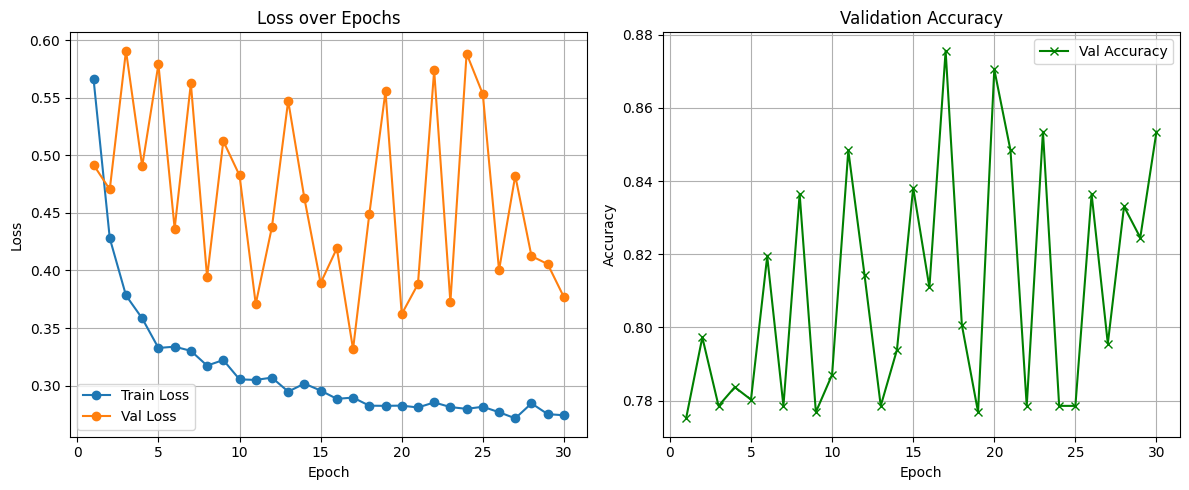

In [29]:
##Alternate

# Paths to data CSVs (replace with actual file paths)
eeg_csv_path = '/content/sub-09_run-001_eeg_prc_log.csv'
event_csv_path = '/content/sub-09_run-001_key_log.csv'
fs = 250  # EEG sampling rate

# 1. Load data
print("Loading EEG data...")
eeg_timestamps, eeg_data = load_eeg_data(eeg_csv_path)
print("Loading event data...")
event_times, event_labels = load_event_data(event_csv_path)

# 2. Preprocess (filter EEG)
print("Applying bandpass filter (1-50 Hz)...")
eeg_data = bandpass_filter(eeg_data, fs, lowcut=1.0, highcut=50.0)

# 3. Create event mask and segment into windows
print("Creating event mask...")
event_mask = create_event_mask(eeg_timestamps, event_times, event_labels)
print("Segmenting into windows...")
window_sec = 0.5
step_sec = 0.25
X, y = segment_windows(eeg_data, event_mask, fs, window_sec, step_sec)
print(f"Total windows: {len(y)} (positive: {np.sum(y)})")

# 4. Prepare PyTorch datasets and loaders
dataset = EEGDataset(X, y)

# Split dataset into train, validation, and test sets (e.g., 80/10/10 split)
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

# Ensure lengths sum up to total_len
if train_len + val_len + test_len != total_len:
    test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) # Validation loader
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False) # Test loader

print(f"Dataset split: Train ({train_len}), Validation ({val_len}), Test ({test_len})")


# 5. Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = X.shape[1]        # e.g., 8
n_time = X.shape[2]            # e.g., 125 (0.5s * 250Hz)
model = EEGNet(n_channels=n_channels, n_time=n_time, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. Train and evaluate
# Use the train_model function with the newly created val_loader

train_losses, val_losses, val_accuracies = train_model(
    model,
    train_loader,
    val_loader, # Pass the validation loader
    n_epochs=30,
    lr=0.001,
    save_path='eegnet_best.pth'
)